# Milestone Project 2: SkimLit 📄🔥

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: [https://arxiv.org/abs/1710.06071](https://arxiv.org/abs/1710.06071)

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: [https://arxiv.org/abs/1612.05251](https://arxiv.org/abs/1612.05251)

📖 **Resource:** If you want to find the ground truth for this notebook (with lots of diagrams and text annotations) see the GitHub: [https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb)

Video N°259: Setting up our notebook for Milestone Project 2 (getting the data) 

## Check GPU

In [1]:
from MachineLearningUtils.system_setup.gpu import activate_gpu
activate_gpu()

2024-05-06 22:35:52.198321: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 22:35:52.198360: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 22:35:52.224584: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-06 22:35:52.279291: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


1 Physical GPUs, 1 Logical GPU


2024-05-06 22:35:55.221977: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-06 22:35:55.435430: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-06 22:35:55.435632: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
!nvidia-smi -L

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
GPU 0: NVIDIA GeForce RTX 3050 (UUID: GPU-ee6cd8ff-34bf-dc58-2edb-4f5120aaec55)


## Import libraries

In [3]:
from MachineLearningUtils.data_acquisition.data_downloader import *

## Get data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.
We can do so from the authors GitHub: [https://github.com/Franck-Dernoncourt/pubmed-rct](https://github.com/Franck-Dernoncourt/pubmed-rct)

In [4]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [5]:
!ls pubmed-rct

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [6]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
dev.txt  test.txt  train.txt


In [7]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [8]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

Video N°260: Visualising examples from the dataset (becoming one with the data)

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to...

> Visualize, visualize, visualize 

So with that in mind, let's write a function to read in all of the lines of a target text file.

In [9]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [10]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt") # read the lines with the training file
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [11]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best represented...

```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': "Emotional eating is associated with overeating and the development of obesity .\n"
   'total_lines': 11},
   ...]
```

Let's write a function which turns each of our datasets into the above format so we can continue to prepare our data for modelling.

Video N°261: writing a preprocessing function to structure our data for modelling

In [12]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.
  
  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentnece,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename=filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
    
      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    else:
      abstract_lines += line
  return abstract_samples

In [13]:
%%time
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 281 ms, sys: 44.4 ms, total: 325 ms
Wall time: 324 ms


In [14]:
# Check the first abstract of our training data
train_samples[:8]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Video N°262: Performing visual data analysis on our preprocessed text

Now that our data is the format of a list of dictionaries, how about we trun it into a DataFrame to further visualize it?

In [15]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(20)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [16]:
# Distribution of labels in training data
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

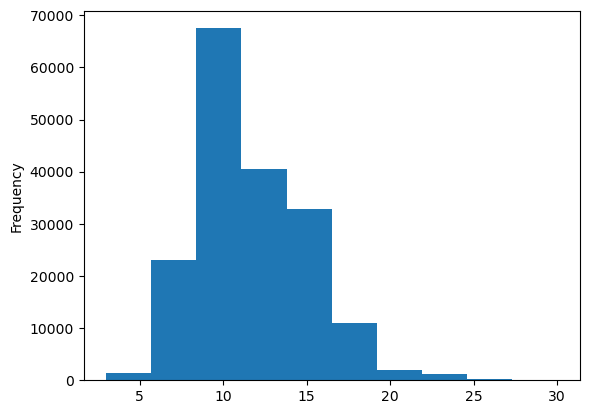

In [17]:
# Let's check the length of different lines
train_df.total_lines.plot.hist(); 

### Get lists of sentences

In [18]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [19]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

Video N°263: Turning our target labels into numbers (ML models require numbers)

## Make numeric labels (ML models require numeric labels)

In [20]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False) # we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [21]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_label_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [22]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

Video N°264: Model 0: Creating, fitting and evaluating a baseline model for SkimLit

## Starting a series of modelling experiments...

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

And as always, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier).

## Model 0: Getting a baseline

A baseline model is an important first step in any series of modelling experiments.

It sets the pace for the subsequent experiments.

It should start with a simple model and later models (with increasing complexity) will try to beat it.

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ('tf-idf', TfidfVectorizer()),
  ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [24]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

In [25]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(X=val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [26]:
from MachineLearningUtils.data_visualization.evaluation_metrics import evaluate_classification_metrics

In [27]:
# Calculate beseline results
baseline_results = evaluate_classification_metrics(y_true=val_labels_encoded,
                                                   y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

Video N°265: Preparing our data for deep sequence models

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [28]:
import numpy as np
from tensorflow.keras import layers

In [29]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [30]:
# How long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

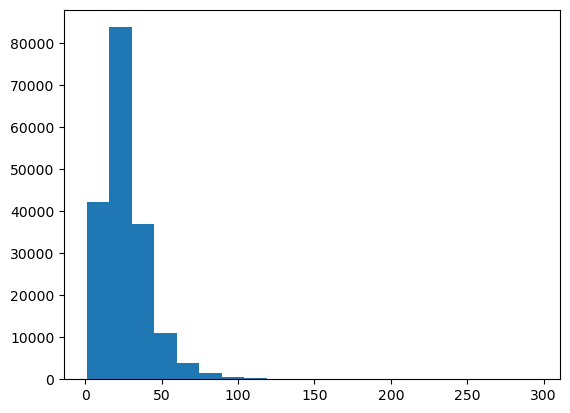

In [31]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)

In [32]:
# How long of a sentence lenght covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [33]:
# Maximum sequence length in the training set
max(sent_lens)

296

Video N°266: Creating a text vectoriser to map our tokens (text) to numbers

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.

In [34]:
# How many words are in our vocab? (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf
max_tokens = 68000

In [35]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences
                                    

In [36]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [37]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLenght of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
in two phase @ trials , improved glycaemic control with long-acting basal insulin analogue ly@ is associated with weight loss in previously insulin-treated patients .

Lenght of text: 25

Vectorized text:
[[    5    51   209   233   170  2633    35     7  2630  2048   277  1079
   3658    20    81     7   174   264     5   660 18573    12     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [38]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [39]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

Video N°267: Creating a custom token embedding layer with TensorFlow

### Create custom text embedding

In [40]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train)
                               mask_zero=True, # use masking to handle variable sequence lengths (save space)
                               name="token_embedding")

In [41]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 in two phase @ trials , improved glycaemic control with long-acting basal insulin analogue ly@ is associated with weight loss in previously insulin-treated patients .

Sentence after vectorization (before embedding):
 [[    5    51   209   233   170  2633    35     7  2630  2048   277  1079
   3658    20    81     7   174   264     5   660 18573    12     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sentence after embedding:
 [[[ 0.01453611 -0.00149783 -0.04511401 ... -0.00444357  0.02462516
    0.04670569]
  [-0.00223446 -0.00337051  0.03117404 ...  0.02498135  0.02718092
   -0.02086478]
  [ 0.04149583 -0.04658203  0.04029464 ... -0.03788286 -0.01081281
   -0.04442681]
  ...
  [-0.03706541 -0.01272891 -0.00577728 ... -0.03339391  0.04465625
    0.02856329]
  [-0.03706541 -0.01272891 -0.00577728 ... 

Video N°268: Creating fast loading dataset with the TensorFlow tf.data.API 

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow `tf.data` API, many of the steps here are discussed at length in these two resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [42]:
import tensorflow as tf
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [43]:
# Take the TensorSliceDataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

Video N°269: Model 1: Building, fitting and evaluating a Conv1D with token embeddings

## Model 1: Conv1D with token embeddings

In [44]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  padding="same",
                  activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(units=num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [45]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [46]:
# Fit the model
history_model_1 = model_1.fit(x=train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3


2024-05-06 22:36:13.845306: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-06 22:36:14.450742: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f00cd159850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-06 22:36:14.450775: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2024-05-06 22:36:14.472274: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715027774.577743   12732 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


562/562 [==============================] - 19s 30ms/step - loss: 0.9140 - accuracy: 0.6408 - val_loss: 0.6926 - val_accuracy: 0.7377
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.6627 - accuracy: 0.7528 - val_loss: 0.6360 - val_accuracy: 0.7689
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.6215 - accuracy: 0.7732 - val_loss: 0.5976 - val_accuracy: 0.7822


In [47]:
# Evaluate on whole validation dataset
model_1.evaluate(x=valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5990 - accuracy: 0.7855


[0.598961353302002, 0.7855156660079956]

In [48]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 3s 3ms/step


(array([[4.14092332e-01, 1.86137944e-01, 9.43875015e-02, 2.78538436e-01,
         2.68437546e-02],
        [4.28568721e-01, 3.00321490e-01, 1.23411715e-02, 2.50689387e-01,
         8.07918608e-03],
        [1.64410114e-01, 7.31931068e-03, 2.37253238e-03, 8.25849891e-01,
         4.82354735e-05],
        ...,
        [5.88332705e-06, 1.05583400e-03, 1.21848134e-03, 3.84809073e-06,
         9.97715950e-01],
        [5.48607409e-02, 4.76690471e-01, 6.74277768e-02, 7.40626678e-02,
         3.26958358e-01],
        [2.10522547e-01, 6.44477189e-01, 5.99696748e-02, 4.27797139e-02,
         4.22508344e-02]], dtype=float32),
 (30212, 5))

In [49]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [50]:
# Calculate model_1 results
model_1_results = evaluate_classification_metrics(y_true=val_labels_encoded,
                                                  y_pred=model_1_preds)
model_1_results

{'accuracy': 78.55156891301469,
 'precision': 0.7818895121509462,
 'recall': 0.7855156891301469,
 'f1': 0.7827661971008993}

In [51]:
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([ True,  True,  True,  True])

**model_1** est meilleur en tout point que **baseline**

Video N°270: Preparing a pretrained embedding layer from TensorFlow Hub for Model 2

## Model 2: Feature extraction with pretrained token embeddings

Now lets use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder (USE): https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings, however, we're going to stick with the later created USE pretrained embeddings.

In [52]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [53]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Setence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 these findings indicate that oxidative stress is associated with dry eye and that hyaluronic acid/vitamin b@ eye drops may attenuate oxidative stress and inflammation , improving dry eye symptoms .
Setence after embedding:
[ 0.05149173  0.05714541  0.02916265  0.00921592  0.03108953  0.04674487
 -0.01069531 -0.05249487 -0.05210697  0.07529122  0.05411709  0.06588293
  0.01515692  0.0369323  -0.02115841  0.05068345 -0.07629073  0.01249497
  0.07556193  0.00987948 -0.02107775 -0.02833737  0.02085427  0.01166823
  0.066648   -0.07410435 -0.01120296 -0.01697768 -0.02693687  0.01929637]

Length of sentence embedding: 512


Video N°271: Model 2:Building, fitting and evaluating a Conv1D model with token embeddings

### Building and fitting an NLP feature extraction model using pretrained embeddings TensorFlow Hub

In [54]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(units=128, activation="relu")(pretrained_embedding)
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(units=num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [55]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [56]:
# Fit model_2 to the data
history_model_2 = model_2.fit(x=train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 18ms/step - loss: 0.9174 - accuracy: 0.6502 - val_loss: 0.7960 - val_accuracy: 0.6882
Epoch 2/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7683 - accuracy: 0.7010 - val_loss: 0.7540 - val_accuracy: 0.7058
Epoch 3/3
562/562 [==============================] - 9s 17ms/step - loss: 0.7520 - accuracy: 0.7126 - val_loss: 0.7383 - val_accuracy: 0.7158


In [57]:
# Evaluate on the whole validation dataset
model_2.evaluate(x=valid_dataset)

945/945 [==============================] - 13s 14ms/step - loss: 0.7415 - accuracy: 0.7140


[0.7415294647216797, 0.7140209078788757]

In [58]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 13s 13ms/step


array([[4.3704566e-01, 3.6042646e-01, 2.5863408e-03, 1.9166541e-01,
        8.2761431e-03],
       [3.4680507e-01, 5.0107670e-01, 4.0246514e-03, 1.4513865e-01,
        2.9549855e-03],
       [2.4799927e-01, 1.4679289e-01, 2.2396494e-02, 5.4080343e-01,
        4.2007860e-02],
       ...,
       [1.6374121e-03, 5.0344057e-03, 5.1280357e-02, 8.6159504e-04,
        9.4118619e-01],
       [3.1986388e-03, 4.7573455e-02, 1.9865707e-01, 1.1650424e-03,
        7.4940580e-01],
       [1.7492503e-01, 2.4756366e-01, 5.0745648e-01, 6.8040299e-03,
        6.3250892e-02]], dtype=float32)

In [59]:
# Convert the prediction probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [60]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = evaluate_classification_metrics(y_true=val_labels_encoded,
                                                  y_pred=model_2_preds)
model_2_results

{'accuracy': 71.4020918840196,
 'precision': 0.714846514005837,
 'recall': 0.7140209188401959,
 'f1': 0.710925918811986}

In [61]:
np.array(list(model_2_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False,  True])

**model_2** n'a que le f1 de mieux que le **baseline**, bof bof...

Video N° 272: Creating a character-level tokeniser with TensorFlow's TextVectorization layer

## Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.

Previously we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings. 

### Creating a character-level tokenizer

In [62]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [63]:
# Make function to split sentences into characters
def split_chars(text):
    return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

't h e s e   f i n d i n g s   i n d i c a t e   t h a t   o x i d a t i v e   s t r e s s   i s   a s s o c i a t e d   w i t h   d r y   e y e   a n d   t h a t   h y a l u r o n i c   a c i d / v i t a m i n   b @   e y e   d r o p s   m a y   a t t e n u a t e   o x i d a t i v e   s t r e s s   a n d   i n f l a m m a t i o n   ,   i m p r o v i n g   d r y   e y e   s y m p t o m s   .'

In [64]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [65]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

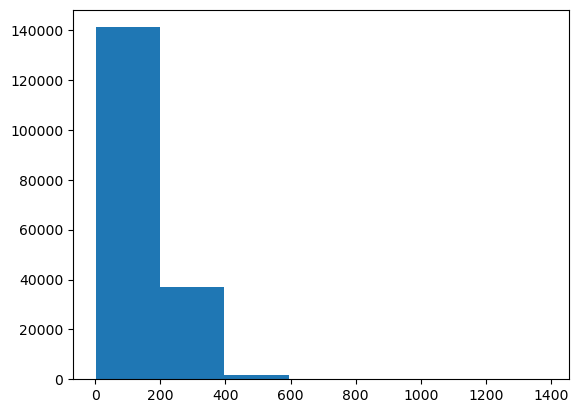

In [66]:
# Check the distribution of our sequences at a character-level
plt.hist(char_lens, bins=7)

In [67]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [68]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [69]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation", # set standardization to "None" if you want to leave punctuation in
                                    name="char_vectorizer")

In [70]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [71]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [72]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 t h e r e   w a s   a   c o r r e l a t i o n   b e t w e e n   t h e   m o t h e r s   '   a n d   t h e   p r e t e r m   i n f a n t s   '   s a l i v a r y   c o r t i s o l   l e v e l s   a t   f o u r   m o n t h s   i n   t h e   s s c   g r o u p   (   =   @   ,   p   =   @   )   ,   b u t   n o t   i n   t h e   s c   g r o u p   (   =   @   ,   p   =   @   )   .

Length of random_train_chars: 142

Vectorized chars:
 [[ 3 13  2  8  2 20  5  9  5 11  7  8  8  2 12  5  3  4  7  6 22  2  3 20
   2  2  6  3 13  2 15  7  3 13  2  8  9  5  6 10  3 13  2 14  8  2  3  2
   8 15  4  6 17  5  6  3  9  9  5 12  4 21  5  8 19 11  7  8  3  4  9  7
  12 12  2 21  2 12  9  5  3 17  7 16  8 15  7  6  3 13  9  4  6  3 13  2
   9  9 11 18  8  7 16 14 14 22 16  3  6  7  3  4  6  3 13  2  9 11 18  8
   7 16 14 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0

Video N°273: Creating a character-level embedding layer with tf.keras.layers.Embedding

### Creating a character-level embedding

In [73]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),  # number of different characters
                              output_dim=25, # this is the size of the char embedding in the paper: https://arxiv.org/pdf/1612.05251.pdf (Figure 1)
                              mask_zero=True,
                              name="char_embed")

In [74]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 t h e r e   w a s   a   c o r r e l a t i o n   b e t w e e n   t h e   m o t h e r s   '   a n d   t h e   p r e t e r m   i n f a n t s   '   s a l i v a r y   c o r t i s o l   l e v e l s   a t   f o u r   m o n t h s   i n   t h e   s s c   g r o u p   (   =   @   ,   p   =   @   )   ,   b u t   n o t   i n   t h e   s c   g r o u p   (   =   @   ,   p   =   @   )   .

Embedded chars (after vectorization and embedding):
 [[[ 0.00941218  0.00056278 -0.04403157 ...  0.01199117 -0.01190813
    0.03141885]
  [ 0.02814272  0.0201554  -0.04181746 ...  0.01660732  0.01360733
   -0.03490042]
  [-0.03102639 -0.0355353  -0.00941258 ... -0.04123066  0.0487004
    0.0335638 ]
  ...
  [-0.00335651  0.00845192 -0.04881561 ... -0.03354906  0.01492042
   -0.03923792]
  [-0.00335651  0.00845192 -0.04881561 ... -0.03354906  0.01492042
   -0.03923792]
  [-0.00335651  0.00845192 -0.04881561 ... -0.03354906  0.01492042
   -0.03923792]]]

Character embedding shape: (1, 290, 25)


Video N°274: Model 3: Building, fitting and evaluating a Conv1D model on character embeddings

### Building a Conv1D model to fit on character embeddings

In [75]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  padding="same",
                  activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(units=num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embeddings")

# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [76]:
# Summary
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 

In [77]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [78]:
# Fit the model on chars only
model_3_history = model_3.fit(x=train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 8ms/step - loss: 1.2428 - accuracy: 0.4960 - val_loss: 1.0347 - val_accuracy: 0.5884
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 1.0001 - accuracy: 0.5993 - val_loss: 0.9386 - val_accuracy: 0.6270
Epoch 3/3
562/562 [==============================] - 4s 6ms/step - loss: 0.9242 - accuracy: 0.6346 - val_loss: 0.8719 - val_accuracy: 0.6589


In [79]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.2405405 , 0.33474222, 0.11380358, 0.2693399 , 0.04157378],
       [0.16354209, 0.48971373, 0.01319779, 0.2942652 , 0.03928119],
       [0.08804679, 0.20402883, 0.08548711, 0.5902799 , 0.0321574 ],
       ...,
       [0.02166799, 0.04491888, 0.1790494 , 0.04837024, 0.70599353],
       [0.01663412, 0.1028221 , 0.35913956, 0.0126667 , 0.5087375 ],
       [0.51100624, 0.28289557, 0.14079258, 0.05644971, 0.00885587]],
      dtype=float32)

In [80]:
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0])>

In [81]:
# Calculate results for Conv1D model chars only
model_3_results = evaluate_classification_metrics(y_true=val_labels_encoded,
                                                  y_pred=model_3_preds)
model_3_results

{'accuracy': 65.52363299351252,
 'precision': 0.6460737858818684,
 'recall': 0.6552363299351252,
 'f1': 0.6434015816585846}

In [82]:
np.array(list(model_3_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

**model_3** fait pire que **baseline** ...

Video N°275: Discussing how we're going to build Model 4 (character + token embeddings)

## Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`) 
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of [https://arxiv.org/pdf/1612.05251.pdf](https://arxiv.org/pdf/1612.05251.pdf)
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

Video N°276: Model 4: Building a multi-input model (hybrid token + character embeddings)

In [83]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(units=128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf

char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout, discussed in section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(rate=0.5)(token_char_concat)
combined_dense = layers.Dense(units=128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(rate=0.5)(combined_dense)
output_layer = layers.Dense(units=num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs= output_layer,
                         name="model_4_token_and_char_embeddings")

In [84]:
# Get a summary of our model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

Video N°277: Model 4: Plotting and visually exploring different data inputs

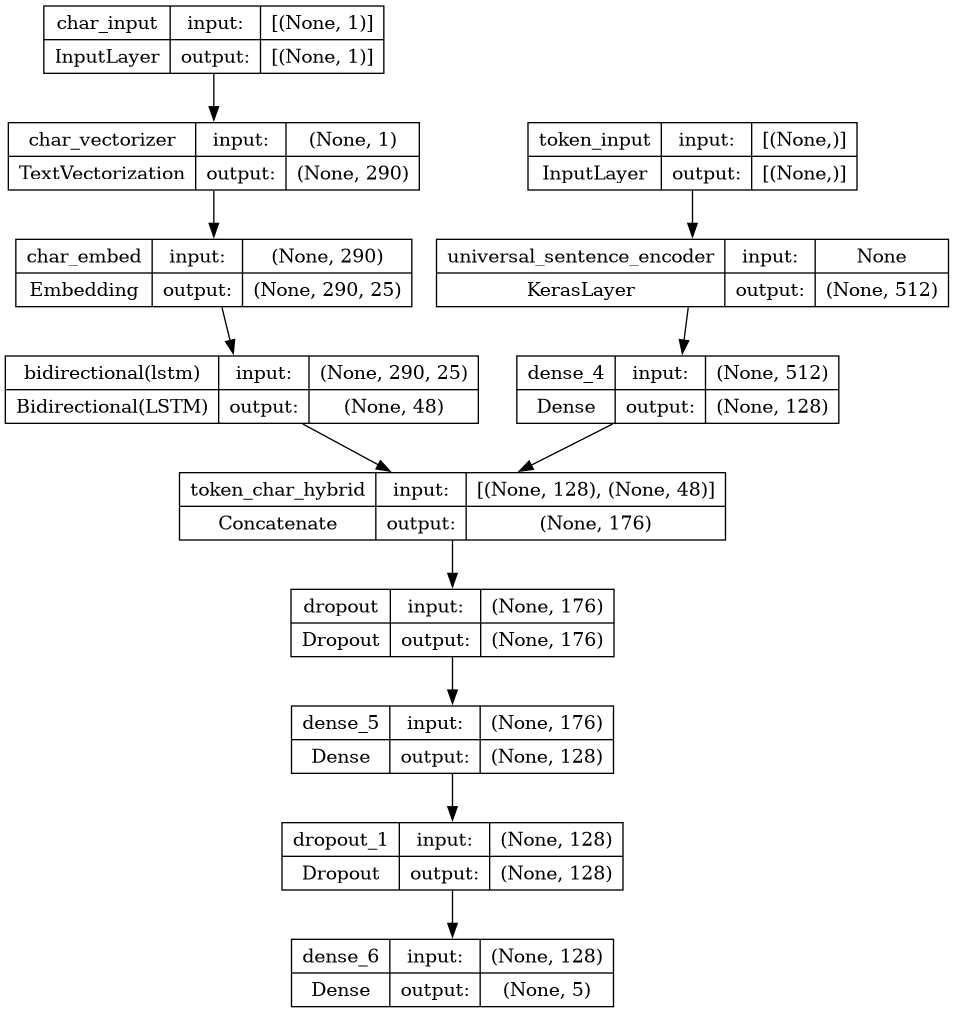

In [85]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [86]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of the paper says they use SGD, you might want to try this
                metrics=["accuracy"])

Video N°278: Crafting multi-input fast loading tf.data dataset for Model 4

### Combining token and character data into a tf.data Dataset

In [87]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices(tensors=(train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(tensors=(train_labels_one_hot)) # make labels
train_char_token_dataset = tf.data.Dataset.zip(datasets=(train_char_token_data, train_char_token_labels)) # combine data and labels
# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [88]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices(tensors=(val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(tensors=(val_labels_one_hot)) # make labels
val_char_token_dataset = tf.data.Dataset.zip(datasets=(val_char_token_data, val_char_token_labels)) # combine data and labels
# Prefetch and batch val data
val_char_token_dataset = val_char_token_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [89]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

Video N°279: Model 4: Building, fitting and evaluating a hybrid embedding model

### Fitting a model on token and character-level sequences

In [90]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(x=train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3


2024-05-06 22:38:51.398127: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_36/output/_23'


562/562 [==============================] - 29s 40ms/step - loss: 0.9875 - accuracy: 0.6026 - val_loss: 0.7742 - val_accuracy: 0.7015
Epoch 2/3
562/562 [==============================] - 21s 36ms/step - loss: 0.8038 - accuracy: 0.6871 - val_loss: 0.7142 - val_accuracy: 0.7281
Epoch 3/3
562/562 [==============================] - 19s 35ms/step - loss: 0.7752 - accuracy: 0.7034 - val_loss: 0.6916 - val_accuracy: 0.7337


In [91]:
# Evaluate one the whole validation dataset
model_4.evaluate(x=val_char_token_dataset)

945/945 [==============================] - 17s 18ms/step - loss: 0.7003 - accuracy: 0.7333


[0.700336217880249, 0.7332847714424133]

In [92]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(x=val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 17s 16ms/step


array([[3.55616152e-01, 4.59575206e-01, 5.49235707e-03, 1.69441000e-01,
        9.87516996e-03],
       [3.29203695e-01, 5.09883940e-01, 4.66031162e-03, 1.54206008e-01,
        2.04602606e-03],
       [2.66918808e-01, 1.04478985e-01, 3.19521017e-02, 5.66497505e-01,
        3.01526189e-02],
       ...,
       [9.57772019e-04, 8.44283402e-03, 7.52308890e-02, 5.44242153e-04,
        9.14824247e-01],
       [1.07089682e-02, 7.61438683e-02, 2.88964212e-01, 6.64040120e-03,
        6.17542565e-01],
       [2.53121674e-01, 2.54036963e-01, 3.85226846e-01, 4.45069410e-02,
        6.31075352e-02]], dtype=float32)

In [93]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 2])>

In [94]:
# Get results of token-char-hybrid model
model_4_results = evaluate_classification_metrics(y_true=val_labels_encoded,
                                                  y_pred=model_4_preds)
model_4_results

{'accuracy': 73.32847875016549,
 'precision': 0.7341701883688054,
 'recall': 0.7332847875016549,
 'f1': 0.7304265923109025}

In [95]:
np.array(list(model_4_results.values())) >np.array(list(baseline_results.values()))

array([ True,  True,  True,  True])

In [96]:
np.array(list(model_4_results.values())) >np.array(list(model_1_results.values()))

array([False, False, False, False])

Video N°280: Model 5: Adding positional embeddings via feature engineering (overview)

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [98]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


Video N°281: Encoding the line number feature to used with Model 5

> 🔑 **Note:** Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

### Create positional embeddings

In [99]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

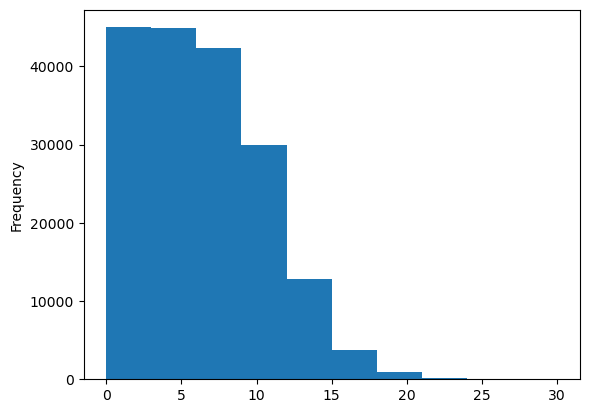

In [100]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [101]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

Video N°282: Encoding the total lines feature to be used with Model 5

Now we've encoded our line numbers feature, let's do the same for our total lines feature...

In [102]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

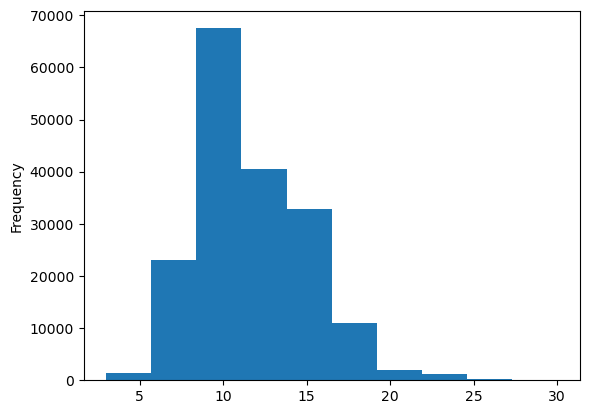

In [103]:
# Check the distributions of total lines
train_df.total_lines.plot.hist()

In [104]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [105]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

Video N°283: Model 5: Building the foundations of a tribrid embedding model

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities 
8. Combine the inputs of 1, 2, 3, 4 and outputs of into a tf.keras.Model